In [174]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from collections import OrderedDict

cmaps = OrderedDict()

In [175]:
import numpy as np
import pandas as pd

In [176]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [177]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [178]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [179]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [180]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [181]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [182]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [183]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)


('2017-08-23',)
2016-08-23


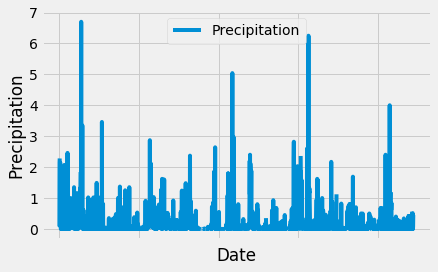

In [184]:
# Perform a query to retrieve the data and precipitation score

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)

precipitation_df.set_index('date', inplace=True)
precipitation_df.head()

# Sort the dataframe by date
precipitation_df.sort_values(by='date', ascending=False)
 
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot()
plt.tight_layout()
# plt.title(“Precipitation by Date for Hawaii”)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(["Precipitation"])
plt.show()

In [215]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.rename(columns={'prcp':'Summary Statistics for Precipitation'}, inplace=True)
precipitation_df.describe()

,Summary Statistics for Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [209]:
# Design a query to show how many stations are available in this dataset?
stations = pd.read_sql("SELECT * FROM Station", conn).dropna(axis=0)
stations['station'].count()


9

In [187]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

precipitation_data = pd.read_sql("SELECT id, station FROM Measurement", conn).dropna(axis=0)
active_stations = precipitation_data.groupby('station').count()
active_stations_count =pd.DataFrame(active_stations)
active_stations_count.rename(columns={'station':'Station id', 'id': 'Data Count Per Station'}, inplace=True)
active_stations_count.sort_values('Data Count Per Station', ascending= False)


,Data Count Per Station
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [188]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
#highest temperature recorded, and average temperature most active station?


most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").all()

most_active


[(54.0, 85.0, 71.66378066378067)]

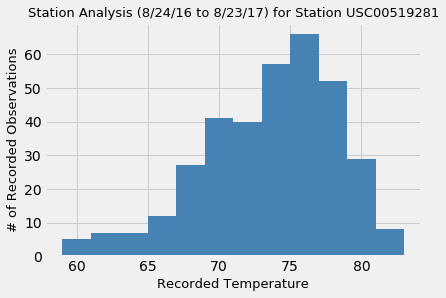

In [189]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_data = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date > last_year).\
filter(Measurement.station == "USC00519281").order_by(Measurement.date).all()

active_station_df =pd.DataFrame(active_station_data)
plt.hist(active_station_df['tobs'],12, color='steelblue')
plt.xlabel("Recorded Temperature", size =13)
plt.ylabel("# of Recorded Observations",size =13)
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station USC00519281", size =13)
plt.show()

In [190]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [192]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = dt.date(2018,4,21)
trip_leave = dt.date(2018,4,30)
last_year = dt.timedelta(days=365)
temp_avg_last_year = (calc_temps((trip_start-last_year), (trip_leave-last_year)))
print(temp_avg_last_year)



[(58.0, 72.90322580645162, 81.0)]


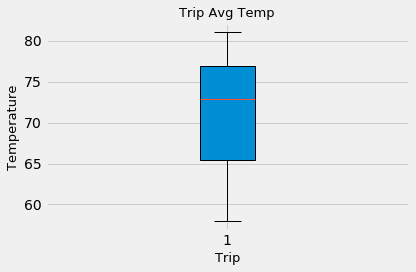

In [200]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
x = range(len(temp_avg_last_year))
ax.boxplot(temp_avg_last_year, patch_artist=True)
ax.set_title('Trip Avg Temp', size =13)
ax.set_ylabel("Temperature", size =13)
ax.set_xlabel("Trip", size =13)
fig.tight_layout()
plt.show()

In [207]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Measurement.date, Station.name, Station.latitude, Station.longitude, Station.elevation,\
            func.sum(Measurement.prcp)).\
    filter(Measurement.date >= trip_start-last_year).\
    filter(Measurement.date <= trip_leave-last_year).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp).all()


[('USC00517948',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  None),
 ('USC00519397',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  14.310000000000008),
 ('USC00514830',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  37.08),
 ('USC00513117',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  58.05000000000005),
 ('USC00519281',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  51.92999999999994),
 ('USC00516128',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  49.58999999999996),
 ('USC00519523',
  '2017-04-21',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  89.37000000000003)]